Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


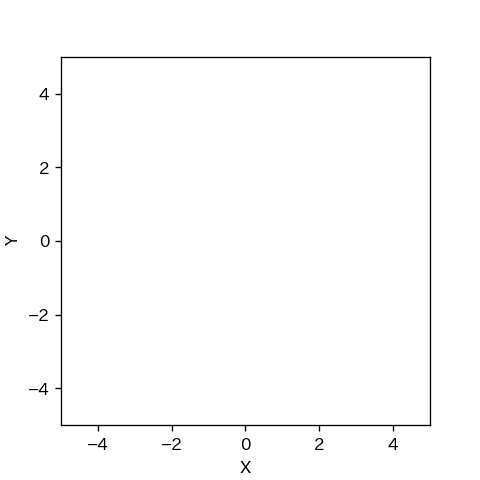

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_phantom_trap_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m, phantom_prob=0.1),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
#, phantom_prob=0.1
    world.draw()
    return (r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


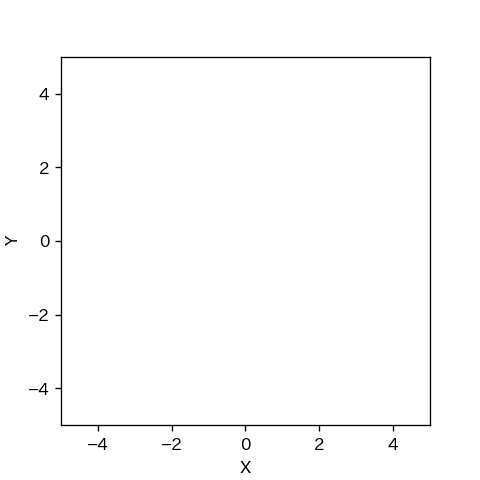

(array([ 3.67267177,  4.28684873, -2.90564803]),
 array([ 2.35651897, -0.94396336,  0.90699707]))

In [4]:
trial_phantom_trap_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_phantom_trap_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

0 真値: [-3.7391612  -4.98911656  1.25291316] 推定値: [-4.86801334  2.26552015  6.74367551] 誤差: 7.341938495136565
1 真値: [-1.32457247 -3.5590998   1.469023  ] 推定値: [ 0.16029692 -5.0913398   8.21845136] 誤差: 2.1336814477865893
[4.287206592254292, 2.169249217207673]
2 真値: [0.48242929 1.54879418 4.30928586] 推定値: [-1.16343571  1.19799423  4.61459787] 誤差: 1.6828345698979672
3 真値: [-1.54519116 -5.55404298  0.94669193] 推定値: [1.06657071 0.60583236 5.2990097 ] 誤差: 6.690692359015429
[0.7691979929621398]
4 真値: [ 2.1944024  -2.91516863  1.1075398 ] 推定値: [ 2.76192311 -2.3328099   1.23069209] 誤差: 0.8131552434328201
1
5 真値: [5.33336124 0.44741729 0.31727071] 推定値: [-1.97546517  2.7925939   4.30715236] 誤差: 7.67585805159993
[2.0726969097079446]
6 真値: [1.34133774 5.72721735 2.62927881] 推定値: [-0.14565884  4.34506688  5.3934794 ] 誤差: 2.0301474661311425
7 真値: [-6.52226965  2.21977775  4.19123002] 推定値: [-0.49874721  3.2356982   1.94675016] 誤差: 6.10859369300359
8 真値: [6.04368358 3.32623986 1.4935438 ] 推定値: [-0.33483

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


20 真値: [-3.75176224  1.05638663  0.42379587] 推定値: [ 2.14533347 -0.93286775  3.9870613 ] 誤差: 6.223573797212635
[6.039279638575827]
21 真値: [ 2.56519342  1.99159734 -0.83824446] 推定値: [ 6.13649596 -4.48183539  3.5746359 ] 誤差: 7.393208580881665
22 真値: [1.8718982  5.40517704 4.03087184] 推定値: [3.95501088 0.30438593 2.2508278 ] 誤差: 5.5097575582938045
[4.166946768609934, 5.344049464487852]
23 真値: [-5.72469727 -0.59240336  4.5527297 ] 推定値: [-4.80304009 -0.34118887  5.15159156] 誤差: 0.955280414297528
3
24 真値: [ 1.99636026 -1.99035345  1.46687395] 推定値: [ 1.67229465 -1.80995833  1.45828442] 誤差: 0.37089205670761993
4
[3.609026936436766]
25 真値: [-6.64296447 -2.55961407  5.09336338] 推定値: [-3.24801886  6.12428108  4.16252123] 誤差: 9.323931080208446
26 真値: [3.11729594 4.42379441 3.24077984] 推定値: [-0.72819326 -1.47770022  5.67669677] 誤差: 7.043821836887691
[6.007985578059419]
27 真値: [-4.45059032  0.0307073   4.52650395] 推定値: [-3.14242401  0.24328685  4.8011499 ] 誤差: 1.3253260614579057
[4.528845653184593]
28